## Import Packages

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

## Slice dataset into smaller chunks for EDA

In [2]:
# sell_prices.csv
price = pd.read_csv('../data/sell_prices.csv')
price_CA1 = price[price['store_id']=='CA_1']
price_CA2 = price[price['store_id']=='CA_2']
price_CA3 = price[price['store_id']=='CA_3']
price_CA1.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
# calendar.csv
calendar = pd.read_csv('../data/calendar.csv')
calendar_train = calendar[:1913]
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
# sales_train_validation.csv
sale = pd.read_csv('../data/sales_train_validation.csv')
sale_CA1 = sale[sale['store_id'] == 'CA_1']
sale_CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Analysis on events during training period (d_1 ~ d_1913)

In [6]:
event1 = calendar_train[['event_name_1','event_type_1']].dropna()
event2 = calendar_train[['event_name_2','event_type_2']].dropna()
ttl_event = pd.concat([event1.rename(columns = {'event_name_1':'event_name','event_type_1':'event_type'}), 
                       event2.rename(columns = {'event_name_2':'event_name','event_type_2':'event_type'})])
print("There are", event1['event_name_1'].nunique(), "unique event_1,", event2['event_name_2'].nunique(), 
      "unique event_2, and",  ttl_event['event_name'].nunique(), "total unique event in the training period.")
print("There are", event1.shape[0], "days have event_1, and", event2.shape[0], 
      "days have event2 while", calendar_train.shape[0]-event1.shape[0], "days do not have any event.")
ttl_event.groupby('event_type').size()

There are 30 unique event_1, 4 unique event_2, and 30 total unique event in the training period.
There are 154 days have event_1, and 4 days have event2 while 1759 days do not have any event.


event_type
Cultural     38
National     51
Religious    53
Sporting     16
dtype: int64

### Analysis on SNAP purchases

* Find how many days which SNAP purchases are allowed in the three states

In [79]:
print("There are totally", sum(calendar['snap_CA']==1), "days where SNAP purchases are allowed in CA.")
print("There are totally", sum(calendar['snap_TX']==1), "days where SNAP purchases are allowed in TX.")
print("There are totally", sum(calendar['snap_WI']==1), "days where SNAP purchases are allowed in WI.")

There are totally 650 days where SNAP purchases are allowed in CA.
There are totally 650 days where SNAP purchases are allowed in TX.
There are totally 650 days where SNAP purchases are allowed in WI.


* Find the dates on which SNAP purchases are allowed in the three states

In [8]:
# CA
snap_date_CA = calendar[calendar['snap_CA']==1]['date'].str[-2:]
snap_date_CA.value_counts().sort_index()

01    65
02    65
03    65
04    65
05    65
06    65
07    65
08    65
09    65
10    65
Name: date, dtype: int64

In [9]:
# TX
snap_date_TX = calendar[calendar['snap_TX']==1]['date'].str[-2:]
snap_date_TX.value_counts().sort_index()

01    65
03    65
05    65
06    65
07    65
09    65
11    65
12    65
13    65
15    65
Name: date, dtype: int64

In [10]:
# WI
snap_date_WI = calendar[calendar['snap_WI']==1]['date'].str[-2:]
snap_date_WI.value_counts().sort_index()

02    65
03    65
05    65
06    65
08    65
09    65
11    65
12    65
14    65
15    65
Name: date, dtype: int64

### Analysis on prices

In [ ]:
# Find missing values in price
# Find the weeks that the weekly avg. price is missing for each item in the CA1 store
price_missing = {}
unq_wm_wk = set(calendar['wm_yr_wk'].unique())
for item in price_CA1['item_id'].unique():
    missing_wk = list(unq_wm_wk - set(price_CA1[price_CA1['item_id']==item]['wm_yr_wk'].unique()))
    if len(missing_wk)>0:
        price_missing[item] = missing_wk
        
# (To be continued)Replace missing weekly avg. prices with the prices of the same item for the same week in other stores
replace_price = pd.Dataframe(columns = ['item_id', 'sell_price'])
replace_price.append('AB')
for k in price_missing.keys():
    for v in price_missing[k]:
        if price_CA2[(price_CA2['item_id']==k) & (price_CA2['w']==v)]['sell_price'].empty:

### Create dataset for prediction

* Reference of LSTM Model:
#### (1) https://towardsdatascience.com/predicting-sales-611cb5a252de
#### (2) https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b

In [11]:
# Transpose 'd_1' to 'd_1913' columns of 'sale'
sale_colname = sale.columns
sale_CA1 = pd.melt(sale[sale['store_id'] == 'CA_1'], id_vars=sale_colname[0:6],
                   value_vars=sale_colname[6:], var_name='d', value_name='sales')
sale_CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [12]:
# Merge 'sale_CA1' with 'calendar' & 'price_CA1'
CA1 = pd.merge(sale_CA1, calendar, how='left', on='d')
CA1_all = pd.merge(CA1, price_CA1, how='left')
CA1_all.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [16]:
df_CA1 = CA1_all[['id','item_id','dept_id','cat_id','d','sales','wm_yr_wk','event_name_1',
                 'event_type_1','event_name_2','event_type_2','snap_CA']].copy()
df_CA1['d_new'] = df_CA1['d'].str[2:].astype('int')
df_CA1['week'] = df_CA1['wm_yr_wk']-11100
df_CA1 = df_CA1.sort_values(['id', 'd_new']).reset_index(drop=True)
df_CA1.head()

,id,item_id,dept_id,cat_id,d,sales,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,d_new,week
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,d_1,3,11101,NaN,NaN,NaN,NaN,0,1,1
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,d_2,0,11101,NaN,NaN,NaN,NaN,0,2,1
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,d_3,0,11101,NaN,NaN,NaN,NaN,0,3,1
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,d_4,1,11101,NaN,NaN,NaN,NaN,1,4,1
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,d_5,4,11101,NaN,NaN,NaN,NaN,1,5,1


### Check whether the sales of FOODS_1_001 of store CA1 is stationary

In [20]:
food1_001_CA1 = df_CA1[df_CA1['item_id']=='FOODS_1_001'][['id','item_id','d_new','sales']].reset_index(drop=True)
food1_001_CA1.head()

,id,item_id,d_new,sales
0,FOODS_1_001_CA_1_validation,FOODS_1_001,1,3
1,FOODS_1_001_CA_1_validation,FOODS_1_001,2,0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,3,0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,4,1
4,FOODS_1_001_CA_1_validation,FOODS_1_001,5,4


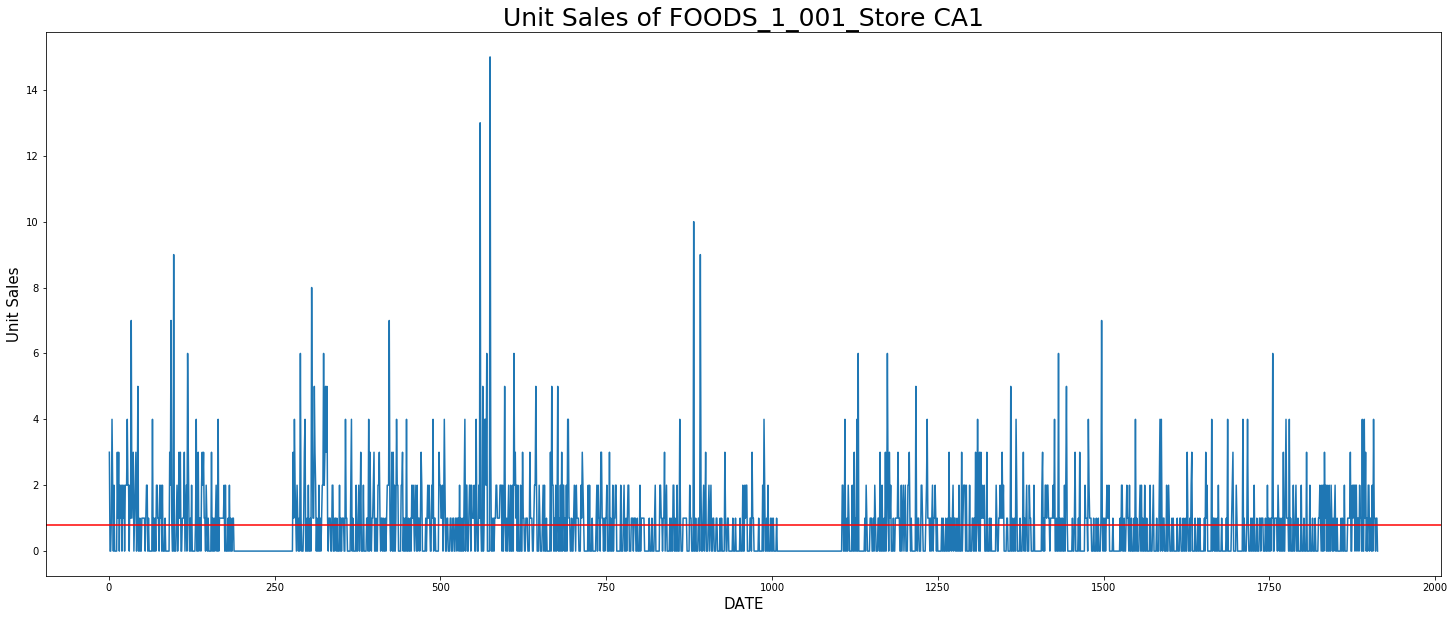

In [21]:
plt.figure(figsize=(25,10))
avg_food1_001_sales = food1_001_CA1['sales'].mean()
plt.plot('d_new', 'sales', data=food1_001_CA1)
plt.axhline(avg_food1_001_sales, color='red')
plt.xlabel('DATE', fontsize=15)
plt.ylabel('Unit Sales', fontsize=15)
plt.title('Unit Sales of FOODS_1_001_Store CA1', fontsize=25)
plt.show()

In [22]:
# Create new dataframes to model the sales difference
food1_001_sale_diff_CA1 = food1_001_CA1.copy()

# Add previous sales to the next row
food1_001_sale_diff_CA1['prev_sales'] = food1_001_sale_diff_CA1['sales'].shift(1)

# Drop the null values and calculate the difference
food1_001_sale_diff_CA1 = food1_001_sale_diff_CA1.dropna()
food1_001_sale_diff_CA1['diff'] = food1_001_sale_diff_CA1['sales'] - food1_001_sale_diff_CA1['prev_sales']
    
food1_001_sale_diff_CA1.head()

,id,item_id,d_new,sales,prev_sales,diff
1,FOODS_1_001_CA_1_validation,FOODS_1_001,2,0,3.0,-3.0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,3,0,0.0,0.0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,4,1,0.0,1.0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,5,4,1.0,3.0
5,FOODS_1_001_CA_1_validation,FOODS_1_001,6,2,4.0,-2.0


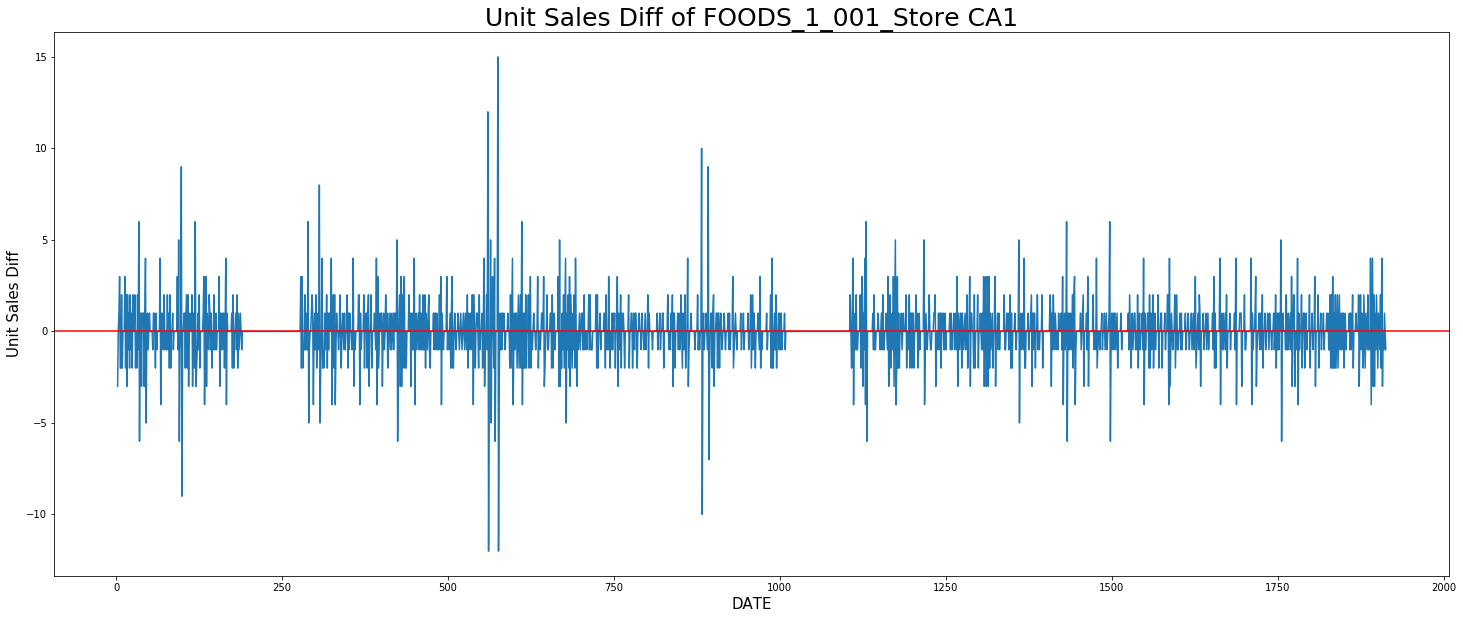

In [23]:
plt.figure(figsize=(25,10))
plt.plot('d_new', 'diff', data=food1_001_sale_diff_CA1)
avg_food1_001_sales_diff = food1_001_sale_diff_CA1['diff'].mean()
plt.axhline(avg_food1_001_sales_diff, color='red')
plt.xlabel('DATE', fontsize=15)
plt.ylabel('Unit Sales Diff', fontsize=15)
plt.title('Unit Sales Diff of FOODS_1_001_Store CA1', fontsize=25)
plt.show()

In [26]:
food1_001_sale_diff_CA1.head(40)

,id,item_id,d_new,sales,prev_sales,diff
1,FOODS_1_001_CA_1_validation,FOODS_1_001,2,0,3.0,-3.0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,3,0,0.0,0.0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,4,1,0.0,1.0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,5,4,1.0,3.0
5,FOODS_1_001_CA_1_validation,FOODS_1_001,6,2,4.0,-2.0
6,FOODS_1_001_CA_1_validation,FOODS_1_001,7,0,2.0,-2.0
7,FOODS_1_001_CA_1_validation,FOODS_1_001,8,2,0.0,2.0
8,FOODS_1_001_CA_1_validation,FOODS_1_001,9,0,2.0,-2.0
9,FOODS_1_001_CA_1_validation,FOODS_1_001,10,0,0.0,0.0
10,FOODS_1_001_CA_1_validation,FOODS_1_001,11,0,0.0,0.0


In [35]:
#create dataframe for transformation from time series to supervised
spv_food1_001 = food1_001_sale_diff_CA1.drop(['prev_sales'],axis=1)

#adding lags
for lag in range(1,366):
    column_name = 'lag_' + str(lag)
    spv_food1_001[column_name] = spv_food1_001['diff'].shift(lag)

#drop null values
spv_food1_001 = spv_food1_001.dropna().reset_index(drop=True)
spv_food1_001.head()

,id,item_id,d_new,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365
0,FOODS_1_001_CA_1_validation,FOODS_1_001,367,0,-4.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,-2.0,2.0,-2.0,-2.0,3.0,1.0,0.0,-3.0
1,FOODS_1_001_CA_1_validation,FOODS_1_001,368,1,1.0,-4.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,-2.0,2.0,-2.0,-2.0,3.0,1.0,0.0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,369,0,-1.0,1.0,-4.0,2.0,2.0,0.0,...,3.0,0.0,0.0,0.0,-2.0,2.0,-2.0,-2.0,3.0,1.0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,370,0,0.0,-1.0,1.0,-4.0,2.0,2.0,...,-2.0,3.0,0.0,0.0,0.0,-2.0,2.0,-2.0,-2.0,3.0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,371,0,0.0,0.0,-1.0,1.0,-4.0,2.0,...,2.0,-2.0,3.0,0.0,0.0,0.0,-2.0,2.0,-2.0,-2.0


In [50]:
regression_adj_rsq = {}
for i in range(365):
    formula_str = 'diff ~ lag_'+str(i+1)
    # Define the regression formula
    model = smf.ols(formula=formula_str, data=spv_food1_001)
    # Fit the regression
    model_fit = model.fit()
    # Extract the adjusted r-squared
    regression_adj_rsq['lag_'+str(i+1)] = model_fit.rsquared_adj
    
{k: v for k, v in sorted(regression_adj_rsq.items(), key=lambda item: item[1],reverse=True)}

{'lag_1': 0.24866244673369275,
 'lag_322': 0.014562232581184165,
 'lag_51': 0.011392451282429716,
 'lag_258': 0.011062111810038133,
 'lag_52': 0.009838385321615295,
 'lag_15': 0.007588696383538984,
 'lag_269': 0.00707976609807881,
 'lag_321': 0.007013935070052324,
 'lag_184': 0.006641137321992563,
 'lag_183': 0.006222633771693409,
 'lag_270': 0.006127953746599912,
 'lag_50': 0.005858119253374872,
 'lag_271': 0.005516442452401571,
 'lag_299': 0.005433654566377566,
 'lag_31': 0.004952508203929007,
 'lag_124': 0.00474419377688895,
 'lag_259': 0.004700259565563747,
 'lag_117': 0.004670039822591399,
 'lag_123': 0.004040260105177773,
 'lag_262': 0.003932756069503163,
 'lag_108': 0.0036915647851124556,
 'lag_109': 0.0036619988475246057,
 'lag_319': 0.003569116694802643,
 'lag_57': 0.0034571816082772377,
 'lag_218': 0.003450611688867622,
 'lag_88': 0.0033522354315794756,
 'lag_67': 0.003228483105817137,
 'lag_268': 0.0031209304054748976,
 'lag_193': 0.003045342564091391,
 'lag_32': 0.002972091

In [27]:
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+lag_13+lag_14+lag_15+lag_16+lag_17+lag_18+lag_19+lag_20+lag_21+lag_22+lag_23+lag_24+lag_25+lag_26+lag_27+lag_28+lag_29+lag_30', data=spv_food1_001)
#model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7', data=spv_food1_001)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.47797477515134357


### Check whether the sales of each category of store CA1 is stationary

In [28]:
cat_sales_CA1 = df_CA1.groupby(['cat_id','d_new'])['sales'].sum().reset_index()
food_CA1 = cat_sales_CA1[cat_sales_CA1['cat_id']=='FOODS'].reset_index(drop=True)
hobby_CA1 = cat_sales_CA1[cat_sales_CA1['cat_id']=='HOBBIES'].reset_index(drop=True)
household_CA1 = cat_sales_CA1[cat_sales_CA1['cat_id']=='HOUSEHOLD'].reset_index(drop=True)
household_CA1.head()

,cat_id,d_new,sales
0,HOUSEHOLD,1,542
1,HOUSEHOLD,2,520
2,HOUSEHOLD,3,393
3,HOUSEHOLD,4,401
4,HOUSEHOLD,5,330


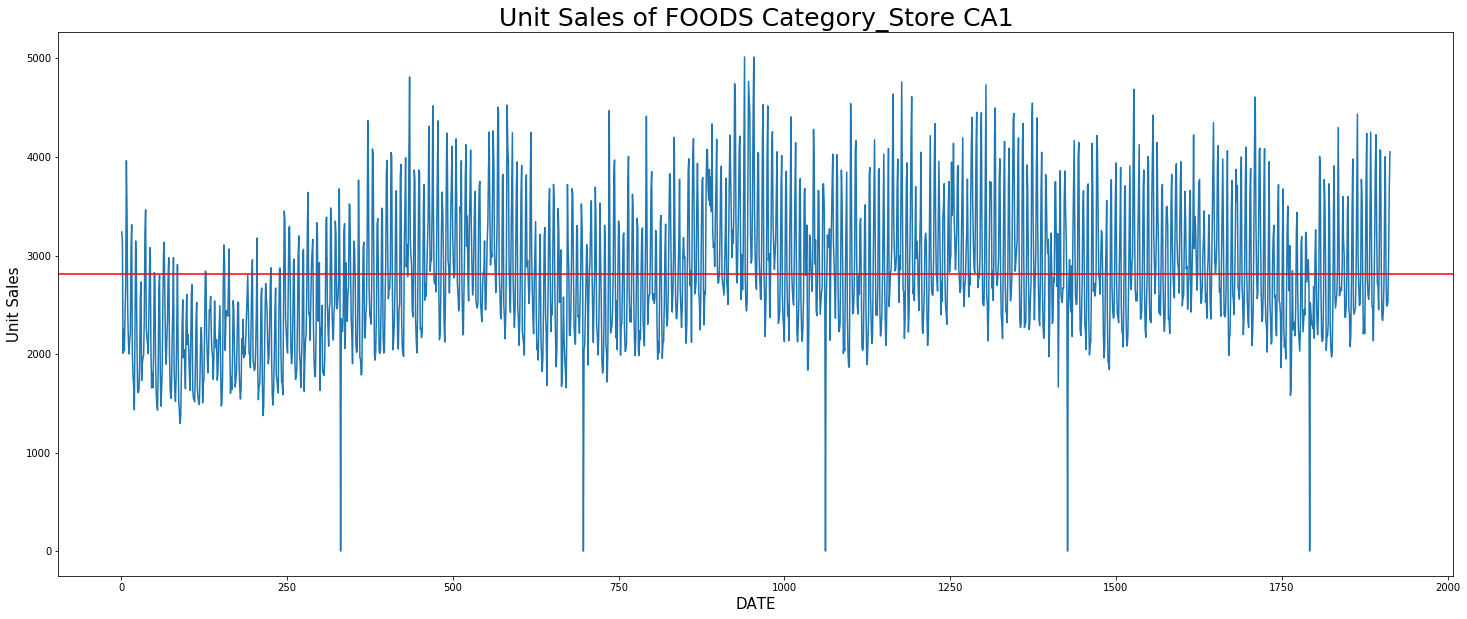

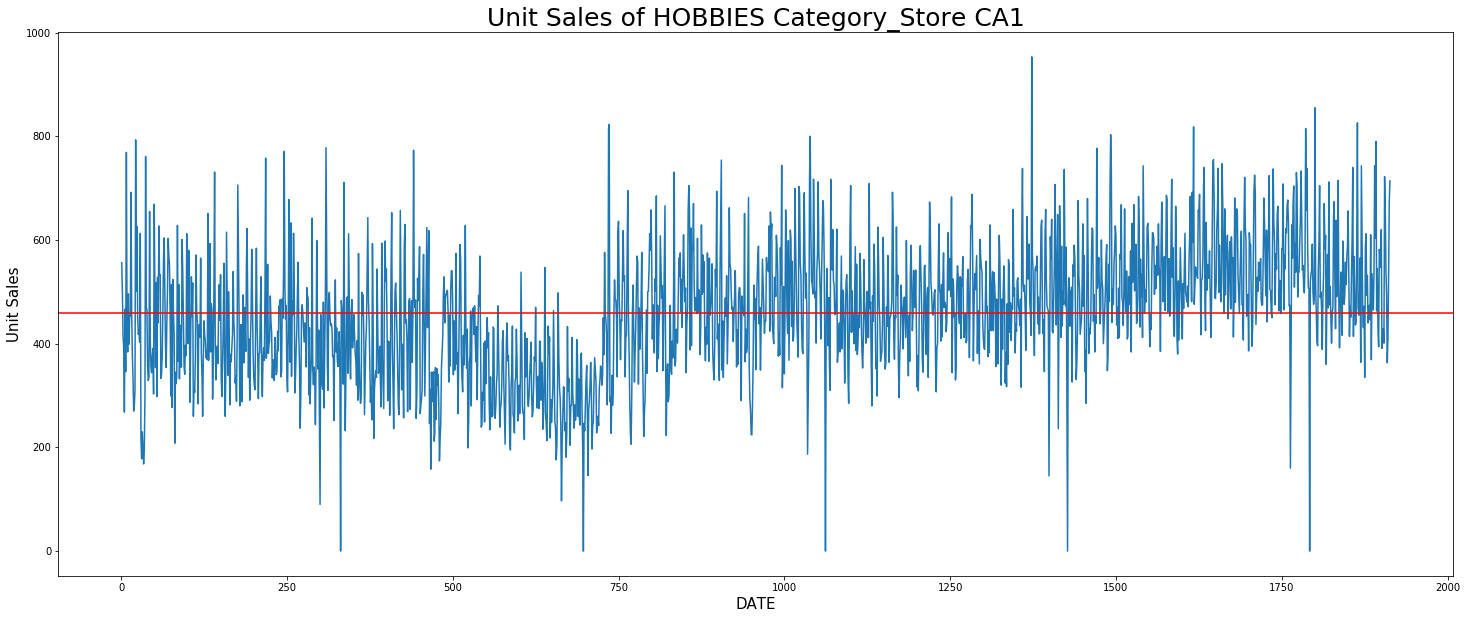

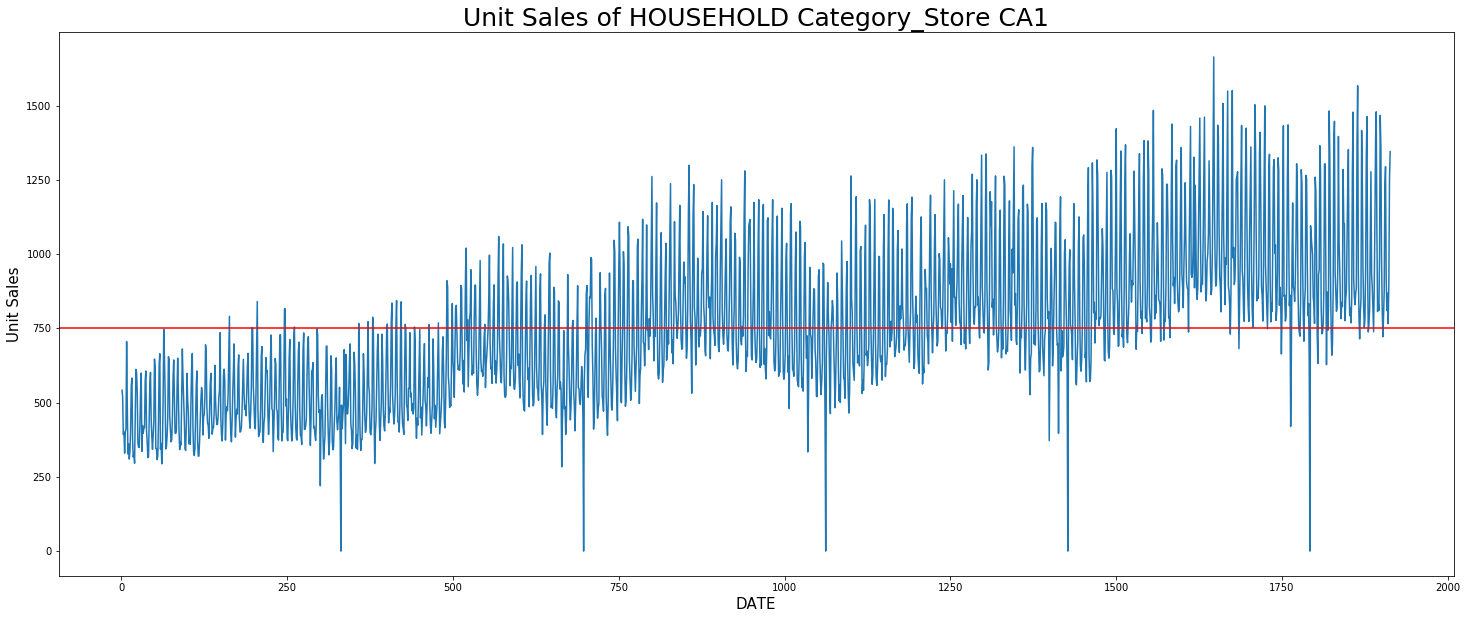

In [29]:
for df_cat in [food_CA1, hobby_CA1, household_CA1]:
    plt.figure(figsize=(25,10))
    avg_cat_sales = df_cat['sales'].mean()
    plt.plot('d_new', 'sales', data=df_cat)
    plt.axhline(avg_cat_sales, color='red')
    plt.xlabel('DATE', fontsize=15)
    plt.ylabel('Unit Sales', fontsize=15)
    plt.title('Unit Sales of ' + df_cat['cat_id'][0] + ' Category_Store CA1', fontsize=25)
    plt.show()

In [30]:
# Create new dataframes to model the sales difference for each category
food_sale_diff_CA1 = food_CA1.copy()
hobby_sale_diff_CA1 = hobby_CA1.copy()
household_sale_diff_CA1 = household_CA1.copy()

# Add previous sales to the next row
food_sale_diff_CA1['prev_sales'] = food_sale_diff_CA1['sales'].shift(1)
hobby_sale_diff_CA1['prev_sales'] = hobby_sale_diff_CA1['sales'].shift(1)
household_sale_diff_CA1['prev_sales'] = household_sale_diff_CA1['sales'].shift(1)

# Drop the null values and calculate the difference
food_sale_diff_CA1 = food_sale_diff_CA1.dropna()
food_sale_diff_CA1['diff'] = food_sale_diff_CA1['sales'] - food_sale_diff_CA1['prev_sales']
hobby_sale_diff_CA1 = hobby_sale_diff_CA1.dropna()
hobby_sale_diff_CA1['diff'] = hobby_sale_diff_CA1['sales'] - hobby_sale_diff_CA1['prev_sales']
household_sale_diff_CA1 = household_sale_diff_CA1.dropna()
household_sale_diff_CA1['diff'] = household_sale_diff_CA1['sales'] - household_sale_diff_CA1['prev_sales']
    
food_sale_diff_CA1.head()

,cat_id,d_new,sales,prev_sales,diff
1,FOODS,2,3137,3239.0,-102.0
2,FOODS,3,2008,3137.0,-1129.0
3,FOODS,4,2258,2008.0,250.0
4,FOODS,5,2032,2258.0,-226.0
5,FOODS,6,2407,2032.0,375.0


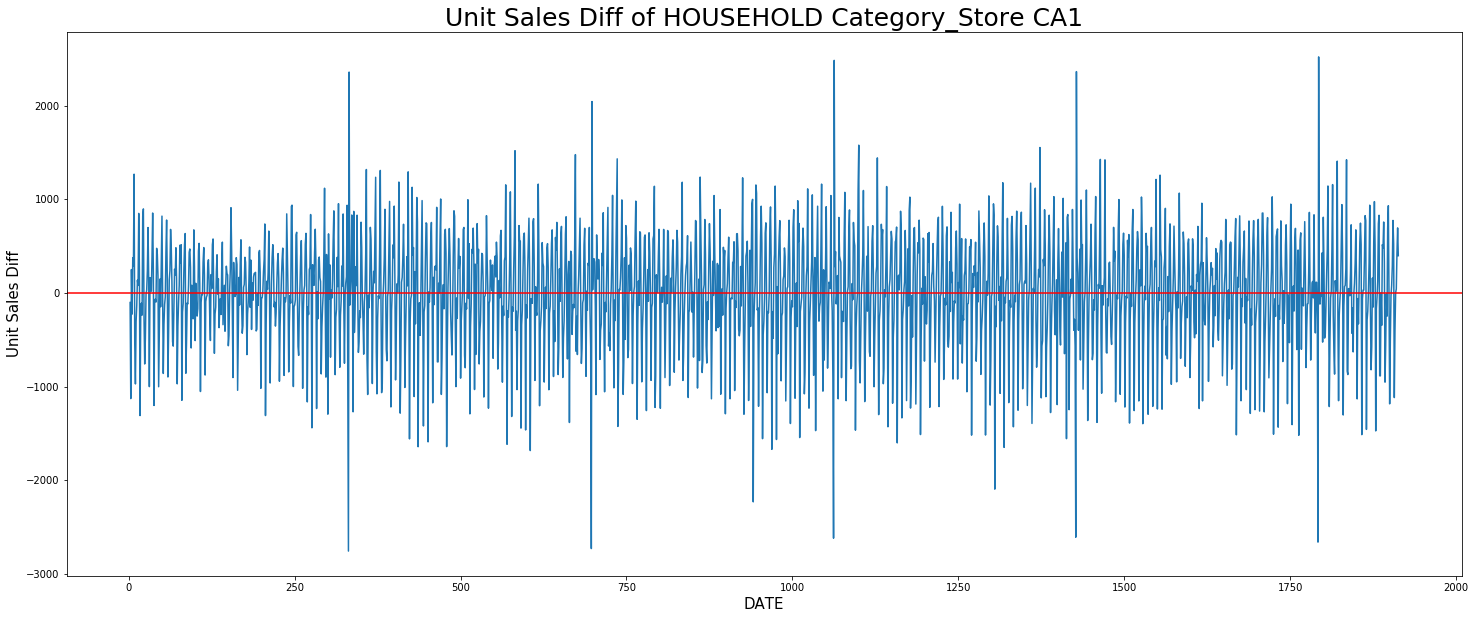

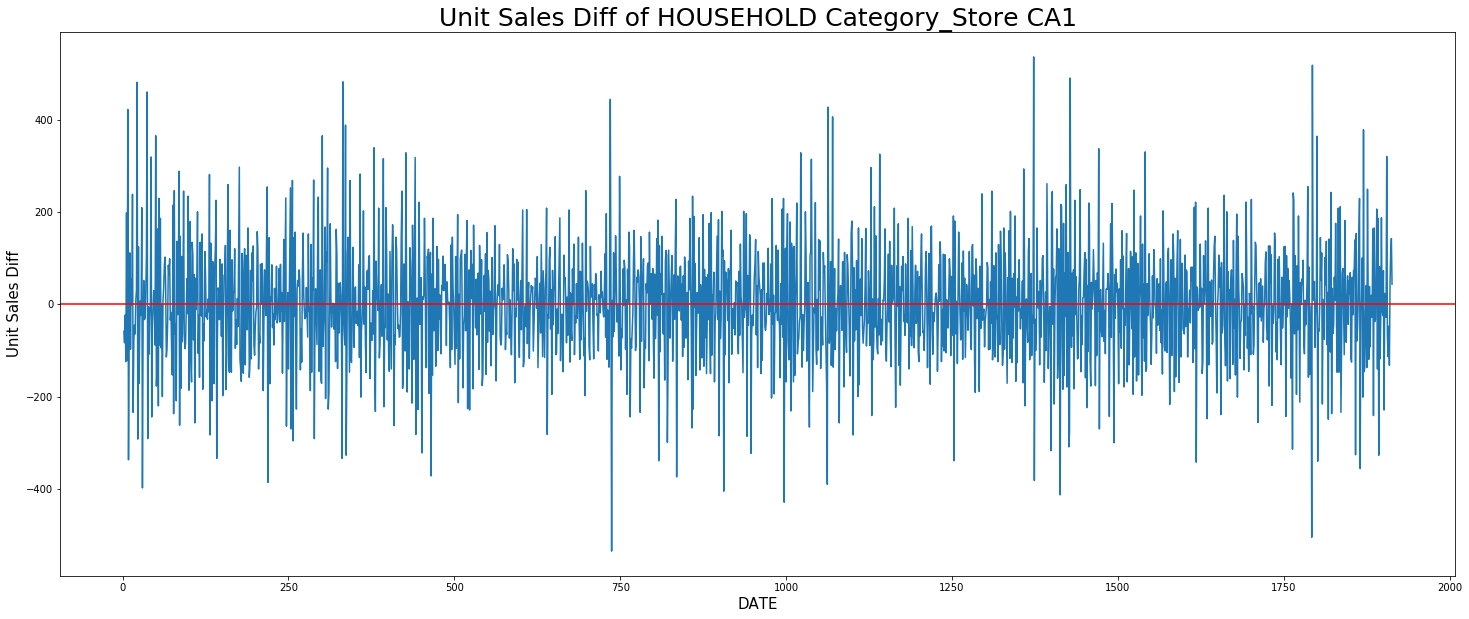

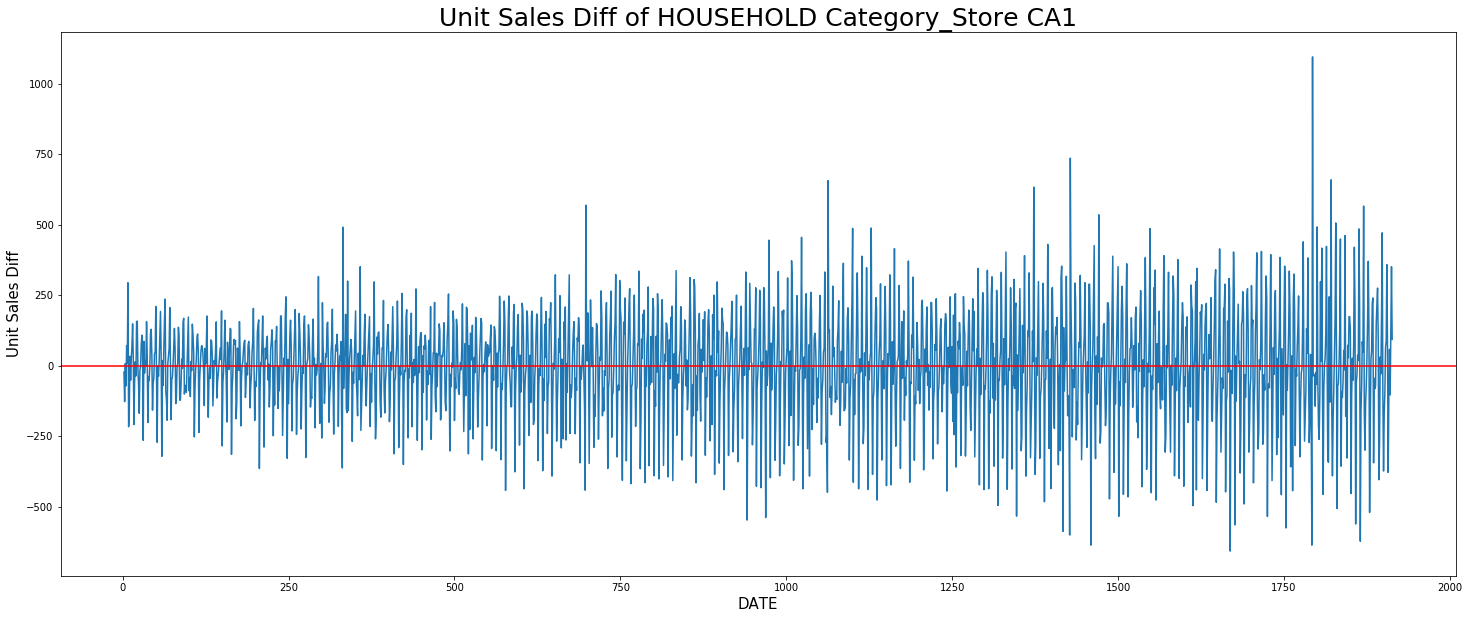

In [31]:
for cat_sale_diff in [food_sale_diff_CA1, hobby_sale_diff_CA1, household_sale_diff_CA1]:
    plt.figure(figsize=(25,10))
    plt.plot('d_new', 'diff', data=cat_sale_diff)
    avg_cat_sales_diff = cat_sale_diff['diff'].mean()
    plt.axhline(avg_cat_sales_diff, color='red')
    plt.xlabel('DATE', fontsize=15)
    plt.ylabel('Unit Sales Diff', fontsize=15)
    plt.title('Unit Sales Diff of ' + df_cat['cat_id'][0] + ' Category_Store CA1', fontsize=25)
    plt.show()

### Build the feature set

### (1) For each item from store CA1

In [195]:
# Create new dataframes to model the sales difference for each item from store CA1
all_food_CA1 = df_CA1[df_CA1['cat_id']=='FOODS'][['id','d_new','sales']]
all_food_CA1 = all_food_CA1.reindex(columns=['id','d_new','sales','prev_sales','diff'])
train_set = np.array([])
test_set = np.array([])

# Add previous sales to the next row
for item in dict_food_CA1:
    df_item = all_food_CA1.groupby('id').get_group(item)
    df_item['prev_sales'] = df_item['sales'].shift(1)
    df_item['diff'] = df_item['sales'] - df_item['prev_sales']
    
    # Create dataframe for transformation from time series to supervised
    df_supervised = df_item.drop(['id','d_new','sales','prev_sales'],axis=1)
    # Adding lags
    for lag in range(1,366):
        column_name = 'lag_' + str(lag)
        df_supervised[column_name] = df_supervised['diff'].shift(lag)
    df_supervised = df_supervised.dropna().reset_index(drop=True)
    
    # Split train and test set
    train, test = df_supervised[0:-28].values, df_supervised[-28:].values
    if train_set.size+test_set.size == 0:
        train_set = train
        test_set = test
    else:
        train_set = np.append(train_set,train, axis=0)
        test_set = np.append(test_set,test, axis=0)

print(train_set.shape)
print(test_set.shape)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(806589, 366)
(14868, 366)


### (2) For each category from store CA1

In [204]:
#create dataframe for transformation from time series to supervised
df_supervised = food_sale_diff_CA1.drop(['prev_sales'],axis=1)

#adding lags
for lag in range(1,366):
    column_name = 'lag_' + str(lag)
    df_supervised[column_name] = df_supervised['diff'].shift(lag)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head()

,cat_id,d_new,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365
0,FOODS,367,2167,-968.0,53.0,576.0,701.0,17.0,-159.0,-22.0,...,-308.0,-972.0,-544.0,1269.0,286.0,375.0,-226.0,250.0,-1129.0,-102.0
1,FOODS,368,2163,-4.0,-968.0,53.0,576.0,701.0,17.0,-159.0,...,-137.0,-308.0,-972.0,-544.0,1269.0,286.0,375.0,-226.0,250.0,-1129.0
2,FOODS,369,2394,231.0,-4.0,-968.0,53.0,576.0,701.0,17.0,...,136.0,-137.0,-308.0,-972.0,-544.0,1269.0,286.0,375.0,-226.0,250.0
3,FOODS,370,2502,108.0,231.0,-4.0,-968.0,53.0,576.0,701.0,...,80.0,136.0,-137.0,-308.0,-972.0,-544.0,1269.0,286.0,375.0,-226.0
4,FOODS,371,3134,632.0,108.0,231.0,-4.0,-968.0,53.0,576.0,...,850.0,80.0,136.0,-137.0,-308.0,-972.0,-544.0,1269.0,286.0,375.0


In [205]:
regression_adj_rsq = {}
for i in range(365):
    formula_str = 'diff ~ lag_'+str(i+1)
    # Define the regression formula
    model = smf.ols(formula=formula_str, data=df_supervised)
    # Fit the regression
    model_fit = model.fit()
    # Extract the adjusted r-squared
    regression_adj_rsq['lag_'+str(i+1)] = model_fit.rsquared_adj
    
{k: v for k, v in sorted(regression_adj_rsq.items(), key=lambda item: item[1],reverse=True)}

{'lag_14': 0.4913319315976321,
 'lag_364': 0.49066161319620016,
 'lag_7': 0.471415835497202,
 'lag_21': 0.4612694623528083,
 'lag_350': 0.45621813956345236,
 'lag_28': 0.44717472876029574,
 'lag_336': 0.4458848028410972,
 'lag_343': 0.4406518859376962,
 'lag_35': 0.44049587728168726,
 'lag_329': 0.43771729947807314,
 'lag_154': 0.433961252563586,
 'lag_196': 0.432318764168913,
 'lag_98': 0.4293207374733925,
 'lag_357': 0.42764965210815997,
 'lag_140': 0.42756689278475635,
 'lag_49': 0.4273639297005807,
 'lag_210': 0.4242474983746902,
 'lag_322': 0.4189239810659734,
 'lag_133': 0.4181669581372641,
 'lag_189': 0.41562939157476664,
 'lag_182': 0.41480872753265785,
 'lag_147': 0.4143666209071962,
 'lag_231': 0.4128184025097892,
 'lag_161': 0.41224721577958867,
 'lag_315': 0.4117902998838997,
 'lag_77': 0.4107324466685255,
 'lag_168': 0.4103701358724068,
 'lag_112': 0.4101094772825611,
 'lag_63': 0.4097552417677105,
 'lag_42': 0.40861715862157044,
 'lag_224': 0.4075900043289661,
 'lag_308':

In [206]:
# Define the regression formula
#model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+lag_13+lag_14+lag_15+lag_16+lag_17+lag_18+lag_19+lag_20+lag_21+lag_22+lag_23+lag_24+lag_25+lag_26+lag_27+lag_28+lag_29+lag_30', data=df_supervised)
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+lag_13+lag_14', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.6994093773862131


In [208]:
# Split train and test set
df_model = df_supervised.drop(['cat_id','d_new','sales'],axis=1)
train_set, test_set = df_model[0:-28].values, df_model[-28:].values

### Scaling data

In [209]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [210]:
train_set

array([[ -968.,    53.,   576., ...,   250., -1129.,  -102.],
       [   -4.,  -968.,    53., ...,  -226.,   250., -1129.],
       [  231.,    -4.,  -968., ...,   375.,  -226.,   250.],
       ...,
       [  740.,   127.,   -44., ...,   656.,   474.,   128.],
       [  830.,   740.,   127., ...,   569.,   656.,   474.],
       [ -885.,   830.,   740., ..., -1154.,   569.,   656.]])

In [211]:
train_set_scaled

array([[-0.32876452,  0.05996573,  0.25909004, ...,  0.14743467,
        -0.37860004,  0.0131604 ],
       [ 0.03826385, -0.32876452,  0.05996573, ..., -0.03414076,
         0.14743467, -0.37860004],
       [ 0.12773653,  0.03826385, -0.32876452, ...,  0.1951173 ,
        -0.03414076,  0.14743467],
       ...,
       [ 0.32153055,  0.08814011,  0.02303446, ...,  0.30230784,
         0.23288194,  0.10089643],
       [ 0.35579669,  0.32153055,  0.08814011, ...,  0.26912073,
         0.30230784,  0.23288194],
       [-0.29716353,  0.35579669,  0.32153055, ..., -0.38813656,
         0.26912073,  0.30230784]])

### Build the LSTM model

In [212]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [213]:
# Fit the LSTM model_trained by:
# (1)item sales diff (takes too much time to train) 
# (2)category sales diff (takes about 7 mins to train)
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0239
Epoch 2/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0174
Epoch 3/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 4/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 5/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0100
Epoch 6/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0085
Epoch 7/100
1519/1519 [==============================] - 4s 2ms/step - loss: 0.0073
Epoch 8/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0062
Epoch 9/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0052
Epoch 10/100
1519/1519 [==============================] - 3s 2ms/step - loss: 0.0044
Epoch 11/100
1519/1519 [==============================] - 4s 2ms/step - loss: 0.0037
Epoch 12/100
1519/1519 [==============================] - 3s 2ms/step - lo

1519/1519 [==============================] - 3s 2ms/step - loss: 4.8441e-04
Epoch 95/100
1519/1519 [==============================] - 3s 2ms/step - loss: 5.1752e-04
Epoch 96/100
1519/1519 [==============================] - 3s 2ms/step - loss: 4.1307e-04
Epoch 97/100
1519/1519 [==============================] - 3s 2ms/step - loss: 4.8459e-04
Epoch 98/100
1519/1519 [==============================] - 3s 2ms/step - loss: 5.2508e-04
Epoch 99/100
1519/1519 [==============================] - 3s 2ms/step - loss: 4.3074e-04
Epoch 100/100
1519/1519 [==============================] - 3s 2ms/step - loss: 4.6310e-04


### Prediction based on the model

In [216]:
y_pred = model.predict(X_test,batch_size=1)

# Inverse transformation for scaling
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [234]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(food_CA1[-28:].d_new)
act_sales = list(food_CA1[-29:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['date'] = sales_dates[index]
    pred_value = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['pred_value'] = pred_value if pred_value>0 else 0
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

df_result

,date,pred_value
0,1886,1830
1,1887,2419
2,1888,2741
3,1889,2531
4,1890,3079
5,1891,4133
6,1892,3746
7,1893,3043
8,1894,3051
9,1895,2657


### Prediction Performance

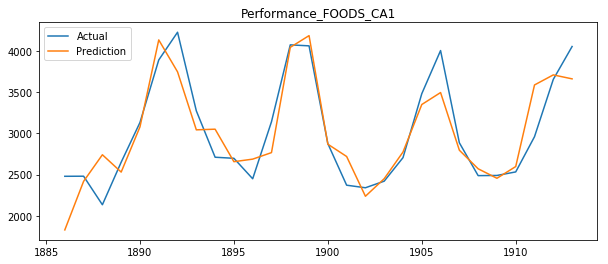

In [241]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(food_CA1['d_new'][-28:], food_CA1['sales'][-28:], label = 'Actual')
ax.plot(df_result['date'], df_result['pred_value'], label = 'Prediction')
ax.set_title('Performance_FOODS_CA1')
ax.legend()